In [1]:
import os
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd




In [126]:
sns.set_palette("pastel")

### 1.Basic File Count

In [42]:
data_path = "../Data/retinal-lesions-v20191227/lesion_segs_896x896/"

In [92]:
all_filenames = []
dirs = []
for dp,dn,files  in os.walk(data_path):
    dirs.append(dn)
    all_filenames.extend(files)
    
dirs = dirs[0]

In [93]:
all_filenames.remove(".DS_Store")

In [ ]:
all_filenames

In [95]:
print(f"Number of annotations : {len(all_filenames)}")
print(f"Number of images : {len(dirs)}")

Number of annotations : 4143
Number of images : 1575


For the 1576 fundus images available, there are 4144 lesion annotations.

### 2.Specific Counts of Each Lesion

In [96]:
lesion_count = Counter(all_filenames)

In [97]:
print("File Decomposition")
for k, v in lesion_count.items():
    if k == ".DS_Store":
        continue
    print(f"{k} : {v}")

File Decomposition
retinal_hemorrhage.png : 1302
cotton_wool_spots.png : 471
microaneurysm.png : 1435
hard_exudate.png : 807
neovascularization.png : 68
fibrous_proliferation.png : 28
vitreous_hemorrhage.png : 13
preretinal_hemorrhage.png : 19


As expected, the most occuring lesions are, microaneurysms, retinal hemorrahages, cotton wool spots (soft exudates), and hard exudates.

### 3. Fundus specific lesion analysis

#### 3.1 File_name correction

In [98]:
cleaned_filenames = []

for fn in all_filenames:
    cleaned_filenames.append(fn[:-4])

#### 3.2 Variable declarations

In [99]:
ihe = "retinal_hemorrhage"
se = "cotton_wool_spots"
he = "hard_exudate"
ma = "microaneurysm"

lesion_indices = {ihe:0, se:1, he:2, ma:3}
lesion_names = {0:ihe, 1:se, 2:he, 3:ma}

In [100]:
len(dirs)

1575

In [145]:
lesion_matrix = np.zeros((len(dirs)+1, 4))

#### 3.3 Analysis of how many fundus images contain all or none of the lesions

In [146]:
i = 0 
for dp,dn,fns in os.walk(data_path):

    for fn in fns:
        if fn == ".DS_Store":
            continue
        try:
            n = lesion_indices[fn[:-4]]
            lesion_matrix[i,n] = 1
        except KeyError:
            continue
    i += 1

In [147]:
lesion_matrix = lesion_matrix[1:]

In [148]:
lesion_matrix

array([[1., 1., 0., 1.],
       [1., 0., 0., 1.],
       [1., 0., 1., 1.],
       ...,
       [1., 1., 1., 1.],
       [1., 1., 0., 1.],
       [1., 1., 1., 1.]])

In [78]:
lesion_matrix.shape

(1575, 4)

In [105]:


i = 0
all_lesions = 0
no_lesions = 0
for r in lesion_matrix:
    if np.allclose(r, np.ones(4)):
        all_lesions += 1
    elif np.allclose(r, np.zeros(4)):
        no_lesions += 1
        print(i)
    i += 1
    

print(f"The number of fundus images with no lesions: {no_lesions}")
print(f"The number of fundus images with all lesions: {all_lesions}")

The number of fundus images with no lesions: 0
The number of fundus images with all lesions: 283


There are no fundus images which have no lesions at all.

In [106]:
avg_lesions = len(all_filenames) / len(dirs)
print(f"The average number of lesions per eye : {round(avg_lesions)}")

The average number of lesions per eye : 3


### 4 Analysis on DR grades

In [107]:
dr_grades = pd.read_csv("../Data/retinal-lesions-v20191227/dr_grades.csv")

In [172]:
dr_grades.head()

,image id,kaggle label,our label
185,9_left,4,4
193,99_right,3,2
723,9990_right,3,3
291,9944_left,2,1
970,9893_right,2,2


In [109]:
dr_grades = dr_grades.sort_values(by="image id", ascending=False)

In [111]:
#dirs = sorted(dirs, reverse=True)

#### 4.1 Plotting how many images belong to each DR grade 

In [119]:
grade_counts = dr_grades["our label"].value_counts()
grades = dr_grades["our label"].unique()

In [300]:
dr_grades_0 = dr_grades[dr_grades["our label"] == 0]
dr_grades_0

,image id,kaggle label,our label
1211,9395_right,2,0
622,8670_right,2,0
951,78_left,2,0
463,7014_right,2,0
197,5760_right,2,0
...,...,...,...
878,10666_left,2,0
1148,10468_left,2,0
233,10244_left,2,0
27,10234_left,1,0


In [120]:
type(grades)

numpy.ndarray

In [123]:
grades = [2, 1, 0, 3, 4]

In [124]:
grade_counts

2    929
1    337
0    166
3     99
4     62
Name: our label, dtype: int64

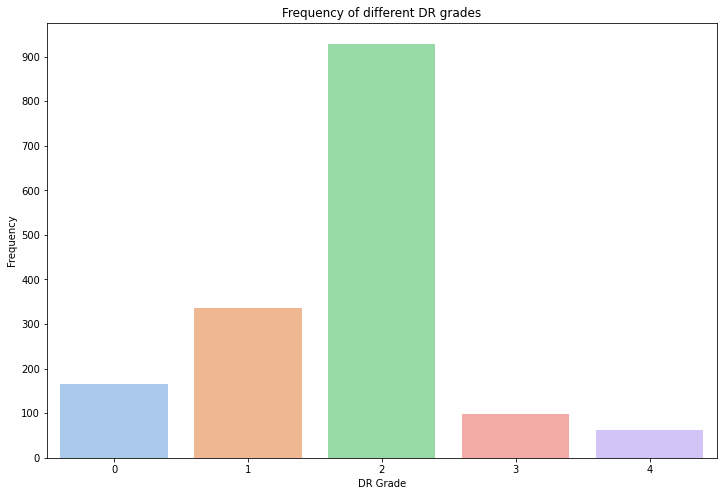

In [136]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))

sns.barplot(x=grades, y=grade_counts, ax=ax)
ax.set_xlabel("DR Grade")
ax.set_ylabel("Frequency")
ax.set_title("Frequency of different DR grades")
ax.set_yticks([n for n in range(0, 1000, 100)])

plt.show()

This analysis shows that the most prevalent eye fundus images belong to DR grade 2, and the DR grades of 3 and 4 contain the least number of images.

This is an imbalanced classification problem.

#### 4.2 Lesion analysis by DR grade

This section will analyse the prevalence of different lesions for different DR grades, in doing so we can determine which type of lesions occur based on the DR grade.

The order of the files in the dr_grades csv is completely different from the order of the files in the directory and the lesion matrix, to ensure that they both are the same, the original lesion matrix and files names will be sorted in descending order, after which the lesion matrix will be added to the dr grades_csv for further analysis.

##### 4.2.0 Sorting the lesion count matrix

In [164]:
dirs_lesions = list(zip(dirs, lesion_matrix))


In [171]:
dirs_lesions[: 5]

[('9_left', array([1., 1., 0., 0.])),
 ('99_right', array([1., 0., 1., 1.])),
 ('9990_right', array([1., 0., 0., 1.])),
 ('9944_left', array([0., 0., 0., 1.])),
 ('9893_right', array([1., 0., 1., 1.]))]

In [166]:
dirs_lesions = sorted(dirs_lesions, reverse=True, key=lambda x: x[0])

In [161]:
dirs_sorted = []
lesion_matrix_sorted = []

for d, lm in dirs_lesions:
    dirs_sorted.append(d)
    lesion_matrix_sorted.append(lm)

In [169]:
lesion_matrix_sorted = np.array(lesion_matrix_sorted)

In [170]:
lesion_matrix_sorted.shape

(1575, 4)

The lesion presence list has been successfully sorted by the file name.

In [230]:
lesion_names = list(lesion_indices.keys())

In [174]:
lesion_names

dict_keys(['retinal_hemorrhage', 'cotton_wool_spots', 'hard_exudate', 'microaneurysm'])

In [ ]:
dr_grades[lesion_names] = lesion_matrix_sorted

##### 4.2.1 Finding the images without segmentation maps

In [204]:
file_names = dr_grades["image id"]

In [205]:
len(file_names)

1593

In [206]:
matches = [item in dirs for item in file_names]

In [211]:

indices_not_present = [i for i,b in enumerate(matches) if not b]
indices_present = [i for i,b in enumerate(matches) if b]

In [212]:
len(indices_not_present)

18

There are 18 images in the dr_grades csv that do not have any segmentation maps.

##### 4.2.2 Including images with only segmentation maps

In [231]:
dr_grades_segs = dr_grades[matches]

In [232]:
dr_grades_segs.head()

,image id,kaggle label,our label
185,9_left,4,4
193,99_right,3,2
723,9990_right,3,3
291,9944_left,2,1
970,9893_right,2,2


In [243]:
lesion_matrix_sorted.astype(np.int8)

array([[1, 1, 0, 0],
       [1, 0, 1, 1],
       [1, 0, 0, 1],
       ...,
       [1, 1, 1, 1],
       [1, 0, 1, 1],
       [1, 0, 0, 1]], dtype=int8)

In [244]:
dr_grades_segs[lesion_names] = lesion_matrix_sorted

<ipython-input-244-86fda1049b67>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dr_grades_segs[lesion_names] = lesion_matrix_sorted


In [246]:
dr_grades_segs

,image id,kaggle label,our label,retinal_hemorrhage,cotton_wool_spots,hard_exudate,microaneurysm
185,9_left,4,4,1.0,1.0,0.0,0.0
193,99_right,3,2,1.0,0.0,1.0,1.0
723,9990_right,3,3,1.0,0.0,0.0,1.0
291,9944_left,2,1,0.0,0.0,0.0,1.0
970,9893_right,2,2,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...
1328,10105_right,2,1,0.0,0.0,0.0,1.0
792,10091_right,2,2,1.0,0.0,1.0,1.0
1039,1008_right,3,3,1.0,1.0,1.0,1.0
885,10047_right,4,2,1.0,0.0,1.0,1.0


In [247]:
dr_grades_segs.to_csv("dr_grades_segs.csv")

##### 4.2.3 Creating a pivot for the data

This pivot will contain the sum of each lesion by DR grade.

In [255]:
grade_pivot = pd.pivot_table(dr_grades_segs, index=["our label"], values=lesion_names,aggfunc=np.sum)

In [267]:
grade_pivot

,cotton_wool_spots,hard_exudate,microaneurysm,retinal_hemorrhage
our label,,,,
0,24.0,27.0,89.0,67.0
1,24.0,59.0,336.0,171.0
2,334.0,606.0,865.0,907.0
3,67.0,82.0,98.0,98.0
4,22.0,33.0,47.0,59.0


##### 4.2.4 Plotting the data

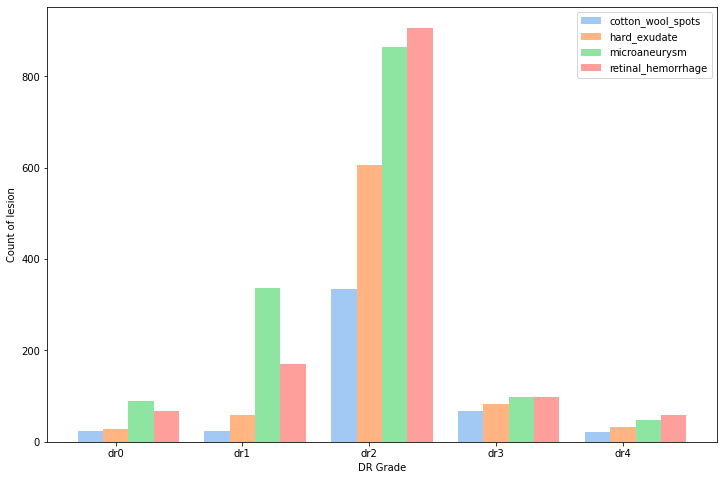

In [294]:
labels = ["dr0", "dr1", "dr2", "dr3", "dr4"]
gp_arr = np.array(grade_pivot)
cws = gp_arr[:, 0]
he = gp_arr[:,1]
ma = gp_arr[:,2]
rhe = gp_arr[:,3]

width = 0.2

x = np.arange(len(labels))

fig, ax = plt.subplots(1 , 1, figsize=(12, 8))

r1 = ax.bar(x - width, cws, width = width, label="cotton_wool_spots")
r2 = ax.bar(x, he, width = width, label="hard_exudate")
r3 = ax.bar(x + width, ma, width = width, label="microaneurysm")
r4 = ax.bar(x + width * 2, rhe, width = width, label="retinal_hemorrhage")

ax.set_xticks(x, labels)
ax.set_ylabel("Count of lesion")
ax.set_xlabel("DR Grade")
ax.legend()




This plot does not show any sort of underlying lesion presence by a specific DR grade, it seems that lesion count is simply based on the number of images for each DR grade, and there is no specific DR grade that contains a higher count of a specific type of lesion. 

This can be observed for DR2 (which has the highest number of images), it shows no specific trend in type of lesion, the two most prevalent types of lesions are the highest for this grade. Moreover, the two most prevalent types of lesions are also the most prevalent for all grades.

### 5 Image analysis by DR Grade

Simply analysing the counts of lesions per DR grade did not reveal any significant patterns in their occurance. This section will conduct an image based analysis of lesion images for different DR grades.

In [299]:
#4531 10454

In [2]:
from tensorflow.keras.utils import load_img

In [8]:



dr_grades = pd.read_csv("../Data/retinal-lesions-v20191227/dr_grades_segs.csv", index_col=0)

In [15]:
dr0 = list(dr_grades[dr_grades["our label"] == 0]["image id"])
dr1 = list(dr_grades[dr_grades["our label"] == 1]["image id"])
dr2 = list(dr_grades[dr_grades["our label"] == 2]["image id"])
dr3 = list(dr_grades[dr_grades["our label"] == 3]["image id"])
dr4 = list(dr_grades[dr_grades["our label"] == 4]["image id"])

In [17]:
seg_path = "../Data/retinal-lesions-v20191227/lesion_segs_896x896/"

In [ ]:
cws = []
ihe = []
he = []
rhe = []
for fn in dr0:
    seg_dir = os.path.join(seg_path, fn)
    for si in os.listdir(seg_dir):
        try:
            i = lesion_indices[si[:-4]]
            img_path = os.path.join(seg_dir,si)
            img = load_img(img_path)

        except:
            continue